# LIGO - Gravitational Waves Detectability

**Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks")
from Utilities import plot_settings

Load downsampled data with balanced classes members

In [2]:
y = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\LIGO_v2\Npy\y.npy")

In [3]:
data = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\LIGO_v2\Npy\data.npy")

In [4]:
keys = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\LIGO_v2\Npy\keys.npy")

In [5]:
df = pd.DataFrame(data, columns=keys)

In [6]:
df = df.drop(columns=['snr', 'det'])

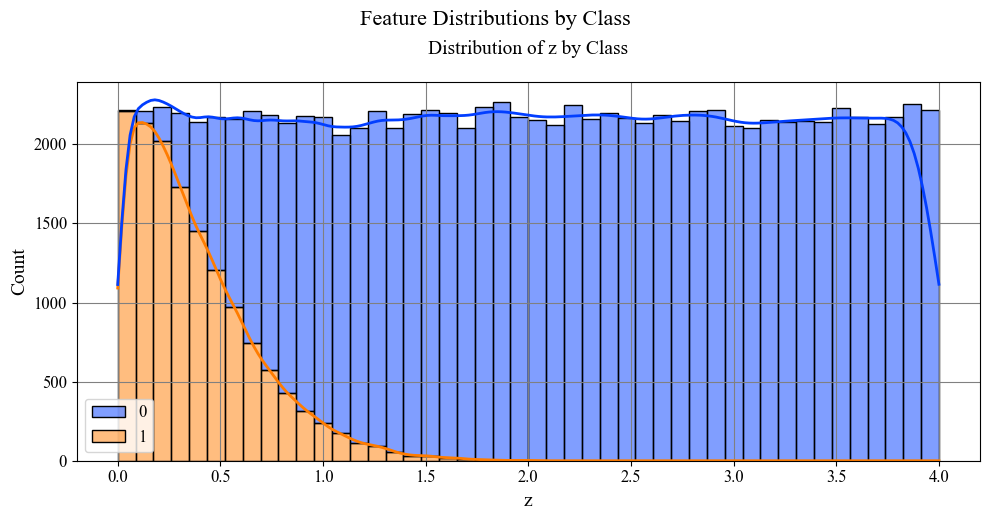

In [7]:
col = 12
sns.histplot(data=df, x=df.columns[col], hue=y, multiple='stack', bins='scott', kde=True, palette='bright')
plt.title(f'Distribution of {df.columns[col]} by Class', fontsize=14)
plt.xlabel(df.columns[col])
plt.ylabel('Count')

plt.tight_layout()
plt.suptitle('Feature Distributions by Class', fontsize=16, y=1.03);

None of the features seems to exhibit an apparent classification boundary.\
Let's try to see what PCA tells me about explained variance ratio.

In [8]:
X = df.to_numpy()

In [9]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

In [10]:
Scaler = RobustScaler()
X_scaled = Scaler.fit_transform(X)

In [11]:
pca = PCA(n_components=int(X.shape[1]))
X_pca = pca.fit_transform(X_scaled)

Text(0, 0.5, 'Explained variance ratio')

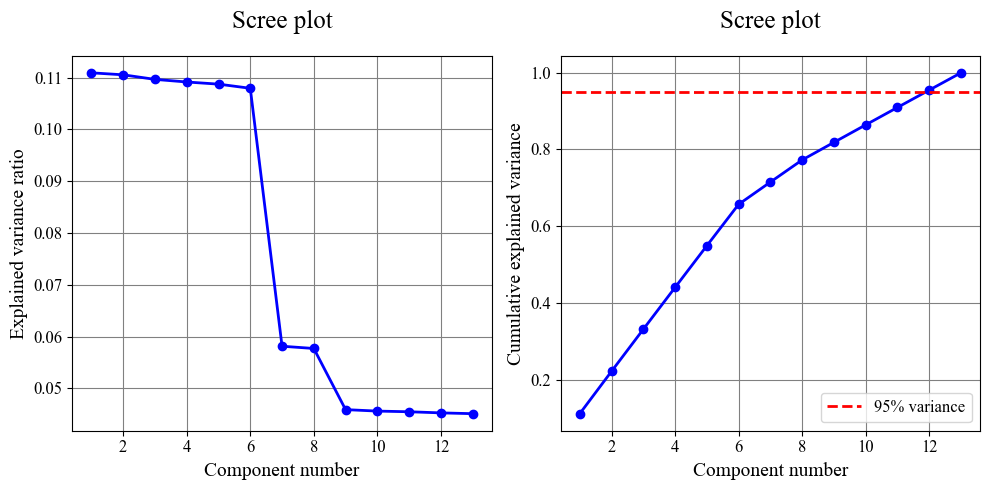

In [12]:
fig, axs = plt.subplots(1, 2)
axs[1].plot(range(1,pca.n_components+1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-', color='blue')
axs[1].set_title('Scree plot')
axs[1].set_xlabel('Component number')
axs[1].axhline(0.95, 0, 1, linestyle='--', color='red', label='95% variance')
axs[1].set_ylabel('Cumulative explained variance')
axs[1].legend()

axs[0].plot(range(1,pca.n_components+1), pca.explained_variance_ratio_, marker='o', linestyle='-', color='blue')
axs[0].set_title('Scree plot')
axs[0].set_xlabel('Component number')
axs[0].set_ylabel('Explained variance ratio')

Looking at the scree plot, to explain $95 \%$ of the variance I'd need at least 12 over 13 features...not encouraging.\
Maybe the relationships between features are non linear. Let's see what LLE has to say about this.

In [13]:
X_ds = X[::10, :]
y_ds = y[::10]

In [14]:
from sklearn.manifold import LocallyLinearEmbedding, TSNE

In [15]:
LLE = LocallyLinearEmbedding(n_components=3, n_neighbors=20)
X_lle = LLE.fit_transform(X_ds)

In [16]:
tsne = TSNE(n_components=3,
            perplexity=30,
            learning_rate=200,
            random_state=42)
X_tsne = tsne.fit_transform(X_ds)

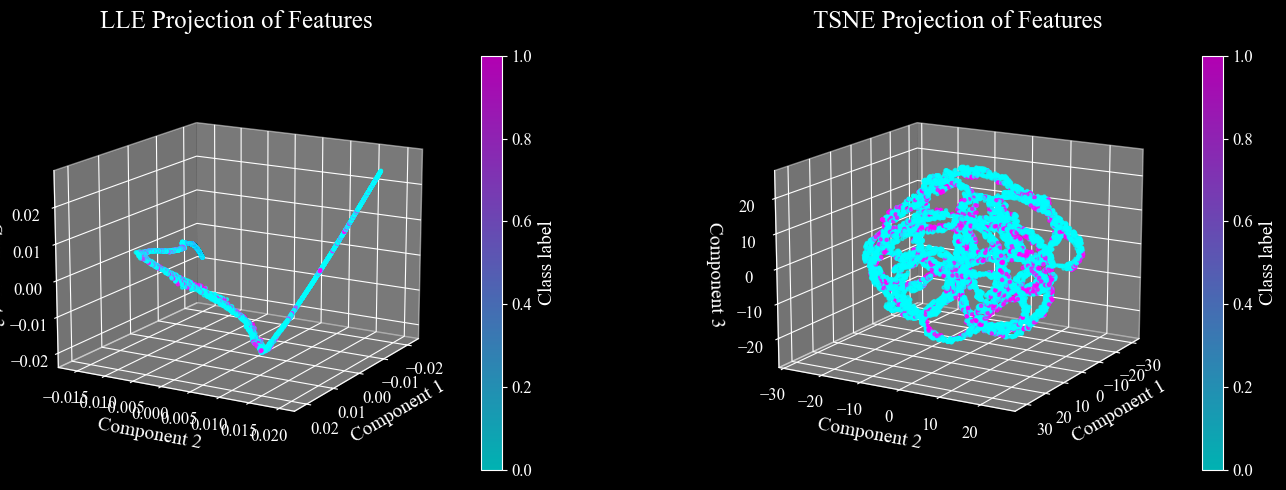

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

with plt.style.context('dark_background'):

    fig = plt.figure(figsize=(15, 5))

    # --- LLE 3D ---
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    p1 = ax1.scatter(X_lle[:, 0], X_lle[:, 1], X_lle[:, 2], c=y_ds, cmap='cool', s=5, alpha=0.7)
    fig.colorbar(p1, ax=ax1, label='Class label')
    ax1.set_title("LLE Projection of Features")
    ax1.set_xlabel("Component 1")
    ax1.set_ylabel("Component 2")
    ax1.set_zlabel("Component 3")

    # --- t-SNE 3D ---
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    p2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y_ds, cmap='cool', s=5, alpha=0.7)
    fig.colorbar(p2, ax=ax2, label='Class label')
    ax2.set_title("TSNE Projection of Features")
    ax2.set_xlabel("Component 1")
    ax2.set_ylabel("Component 2")
    ax2.set_zlabel("Component 3")
    ax2.view_init(elev=15, azim=30)
    ax1.view_init(elev=15, azim=30)

    plt.tight_layout()
    plt.show()

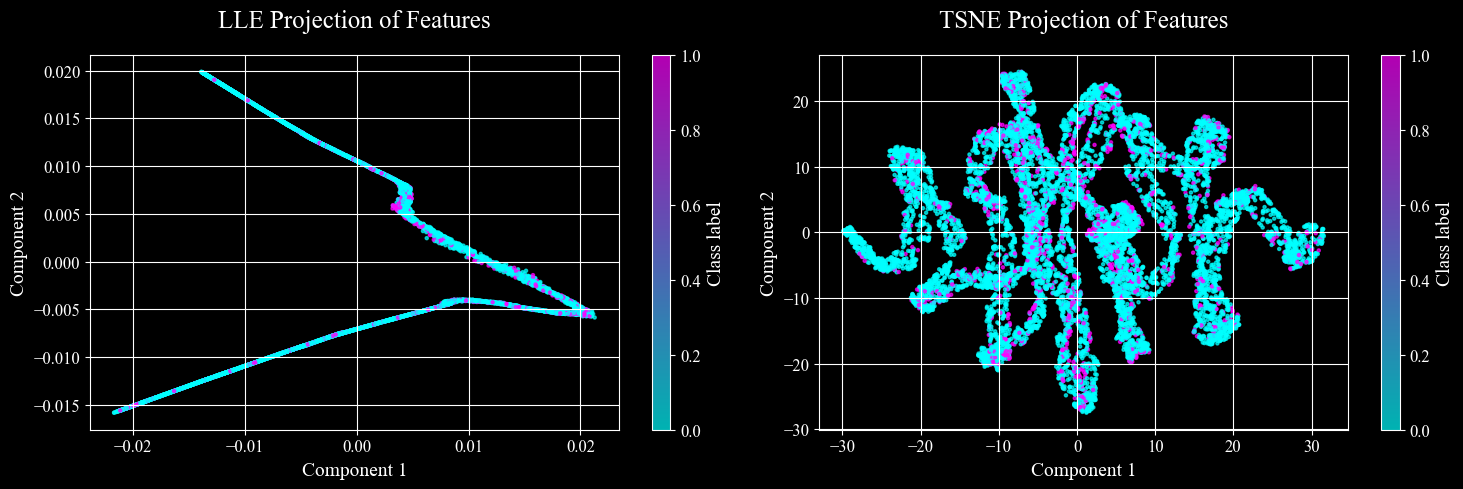

In [18]:
with plt.style.context('dark_background'):

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    scatter = plt.scatter(X_lle[:, 0], X_lle[:, 1], c=y_ds, cmap='cool', s=5, alpha=0.7)
    plt.colorbar(scatter, label='Class label')
    plt.title("LLE Projection of Features")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_ds, cmap='cool', s=5, alpha=0.7)
    plt.colorbar(scatter, label='Class label')
    plt.title("TSNE Projection of Features")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.tight_layout()

I used a downsampled version of my original dataset. It's clear then neitheer of the models are doing well on this task. I'll surrender and use all of the features. But wait... I could use a classification algorithm which selects itself the best sub-set of features that best discriminate the classes, given the data: Random Forest with Boosting!

## Decision Tree

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

S = StandardScaler()
X_train = S.fit_transform(X_train)
X_test  = S.transform(X_test) 
X_val  = S.transform(X_val)

In [20]:
from sklearn.metrics import root_mean_squared_error, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

max_depths = np.linspace(3, 20, 10, dtype=int)

train_errors = []
val_errors = []
roc_curves = {}

for depth in max_depths:
    print(f'Fitting depth: {depth}')
    
    clf = DecisionTreeClassifier(max_depth=depth,
                                 criterion='entropy',
                                 class_weight='balanced',
                                 random_state=42)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)
    y_val_proba = clf.predict_proba(X_val)[:, 1]  # Class 1 prob

    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    val_rmse = root_mean_squared_error(y_val, y_val_pred)

    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
    roc_auc = auc(fpr, tpr)

    train_errors.append(train_rmse)
    val_errors.append(val_rmse)
    roc_curves[depth] = (fpr, tpr, roc_auc)

# --- Best depth ---
best_idx = np.argmin(val_errors)
best_depth = max_depths[best_idx]

print(f"Best max_depth = {best_depth} with validation RMSE = {val_errors[best_idx]:.4f}")

Fitting depth: 3
Fitting depth: 4
Fitting depth: 6
Fitting depth: 8
Fitting depth: 10
Fitting depth: 12
Fitting depth: 14
Fitting depth: 16
Fitting depth: 18
Fitting depth: 20
Best max_depth = 20 with validation RMSE = 0.2121


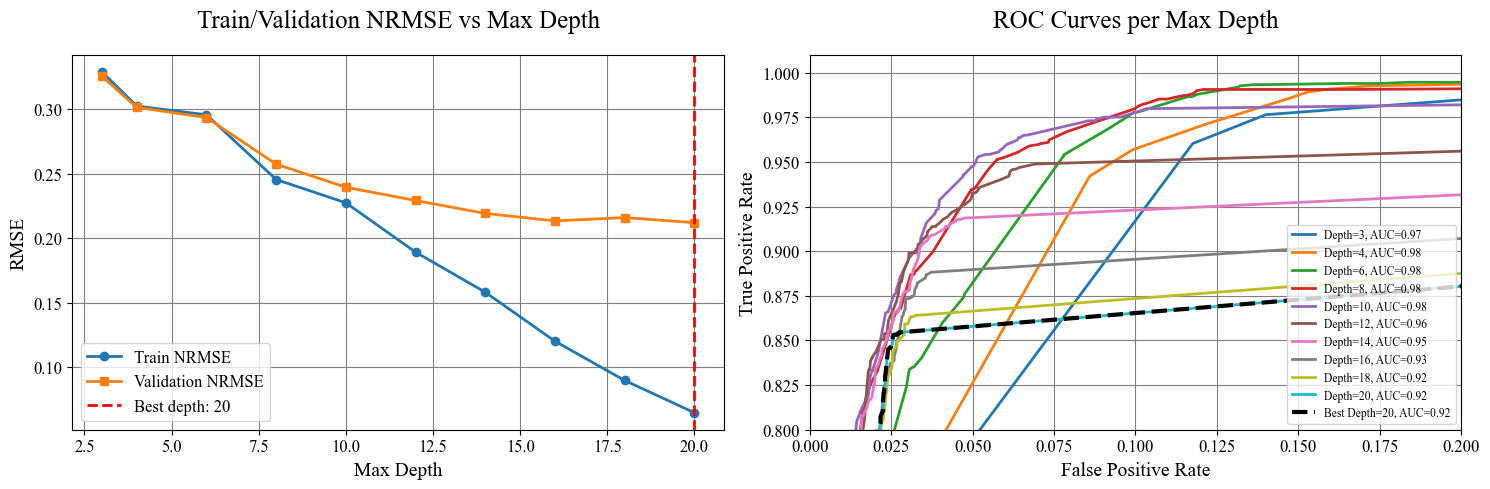

In [21]:
# --- Plot NRMSE vs depth ---
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(max_depths, train_errors, label='Train NRMSE', marker='o')
plt.plot(max_depths, val_errors, label='Validation NRMSE', marker='s')
plt.axvline(best_depth, color='r', linestyle='--', label=f'Best depth: {best_depth}')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.title('Train/Validation NRMSE vs Max Depth')
plt.legend()
plt.grid(True)

# --- Plot ROC curves for every 10th depth ---
plt.subplot(1, 2, 2)
for depth in max_depths:
    fpr, tpr, roc_auc = roc_curves[depth]
    plt.plot(fpr, tpr, lw=2, label=f'Depth={depth}, AUC={roc_auc:.2f}')

# Highlight best depth
fpr, tpr, roc_auc = roc_curves[best_depth]
plt.plot(fpr, tpr, lw=3, color='black', label=f'Best Depth={best_depth}, AUC={roc_auc:.2f}', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Max Depth')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1.01)

plt.tight_layout()
plt.show()

In [22]:
test_pred = clf.predict(X_test)
print(f'Tets RMSE : {root_mean_squared_error(y_test, test_pred):.2}')
fpr, tpr, _ = roc_curve(y_test, test_pred)
print(f'TEST (FPR, TPR) : ({fpr[1]:.2},{tpr[1]:.2})')
print(f'TEST AUC        : {auc(fpr, tpr):.2}')

Tets RMSE : 0.22
TEST (FPR, TPR) : (0.031,0.84)
TEST AUC        : 0.9


This does look nice!\
From a depth value of $10$ on I can see overfitting, thus even if RMSE is best for the maximum depth I've tried, I'll settle for depth of 10.\
Let's see if bagging helps out getting a better AUC.

## Bagging

In [23]:
from sklearn.ensemble import BaggingClassifier

base_classifier = DecisionTreeClassifier(max_depth=5,
                                     criterion='entropy',
                                     class_weight='balanced',
                                     random_state=42)

In [24]:
n_estimators = np.linspace(3, 500, 5, dtype=int)

train_errors = []
val_errors = []
roc_curves = {}

for n in n_estimators:
    print(f'Fitting n: {n}')
    
    clf = BaggingClassifier(
        estimator=base_classifier,
        n_estimators=n,
        random_state=42,
        bootstrap=True,
        n_jobs=-1
    )
    
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)
    y_val_proba = clf.predict_proba(X_val)[:, 1]  

    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    val_rmse = root_mean_squared_error(y_val, y_val_pred)

    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
    roc_auc = auc(fpr, tpr)

    train_errors.append(train_rmse)
    val_errors.append(val_rmse)
    roc_curves[n] = (fpr, tpr, roc_auc)

Fitting n: 3
Fitting n: 127
Fitting n: 251
Fitting n: 375
Fitting n: 500


In [25]:
# --- Best depth ---
best_idx = np.argmin(val_errors)
best_n = n_estimators[best_idx]

print(f"Best max_depth = {best_n} with validation RMSE = {val_errors[best_idx]:.4f}")

Best max_depth = 375 with validation RMSE = 0.2874


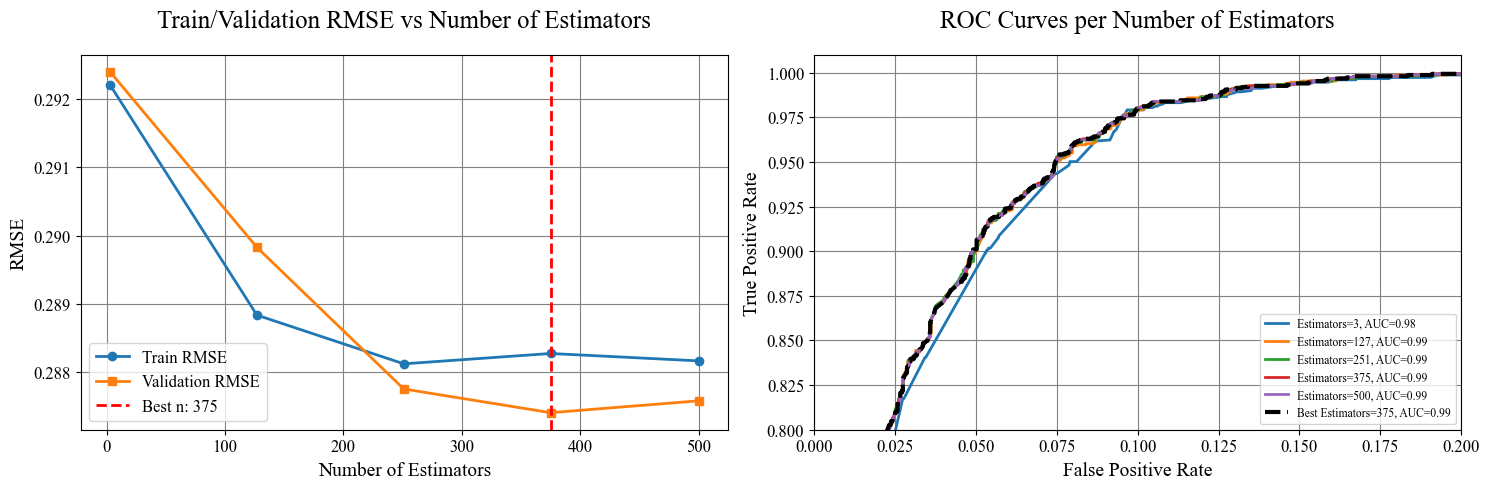

In [26]:
plt.figure(figsize=(15, 5))
# RMSE plot
plt.subplot(1, 2, 1)
plt.plot(n_estimators, train_errors, label='Train RMSE', marker='o')
plt.plot(n_estimators, val_errors, label='Validation RMSE', marker='s')
plt.axvline(best_n, color='r', linestyle='--', label=f'Best n: {best_n}')
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.title('Train/Validation RMSE vs Number of Estimators')
plt.legend()
plt.grid(True)

# ROC plot
plt.subplot(1, 2, 2)
for n in n_estimators:
    fpr, tpr, roc_auc = roc_curves[n]
    plt.plot(fpr, tpr, lw=2, label=f'Estimators={n}, AUC={roc_auc:.2f}')

fpr, tpr, roc_auc = roc_curves[best_n]
plt.plot(fpr, tpr, lw=3, color='black', label=f'Best Estimators={best_n}, AUC={roc_auc:.2f}', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Number of Estimators')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1.01)

plt.tight_layout()
plt.show()

In [27]:
test_pred = clf.predict(X_test)
print(f'Tets RMSE : {root_mean_squared_error(y_test, test_pred):.2}')
fpr, tpr, _ = roc_curve(y_test, test_pred)
print(f'TEST (FPR, TPR) : ({fpr[1]:.2},{tpr[1]:.2})')
print(f'TEST AUC        : {auc(fpr, tpr):.2}')

Tets RMSE : 0.29
TEST (FPR, TPR) : (0.096,0.97)
TEST AUC        : 0.94


## Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
n_estimators = np.linspace(3, 500, 5, dtype=int)

train_errors = []
val_errors = []
roc_curves = {}

for n in n_estimators:
    print(f'Fitting n: {n}')
    
    clf = RandomForestClassifier(
            n_estimators=n,
            max_depth=5,
            criterion='entropy',
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
    
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)
    y_val_proba = clf.predict_proba(X_val)[:, 1]  

    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    val_rmse = root_mean_squared_error(y_val, y_val_pred)

    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
    roc_auc = auc(fpr, tpr)

    train_errors.append(train_rmse)
    val_errors.append(val_rmse)
    roc_curves[n] = (fpr, tpr, roc_auc)

Fitting n: 3
Fitting n: 127
Fitting n: 251
Fitting n: 375
Fitting n: 500


In [30]:
best_idx = np.argmin(val_errors)
best_n = n_estimators[best_idx]

print(f"Best n estimators = {best_n} with validation RMSE = {val_errors[best_idx]:.4f}")

Best n estimators = 127 with validation RMSE = 0.3048


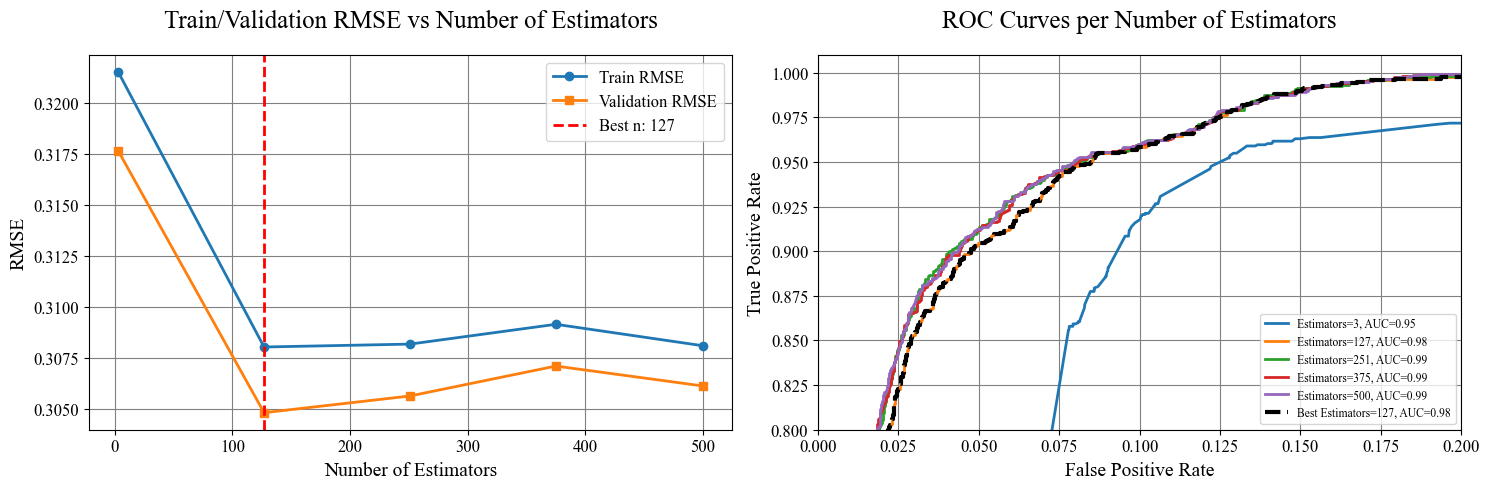

In [31]:
plt.figure(figsize=(15, 5))
# RMSE plot
plt.subplot(1, 2, 1)
plt.plot(n_estimators, train_errors, label='Train RMSE', marker='o')
plt.plot(n_estimators, val_errors, label='Validation RMSE', marker='s')
plt.axvline(best_n, color='r', linestyle='--', label=f'Best n: {best_n}')
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.title('Train/Validation RMSE vs Number of Estimators')
plt.legend()
plt.grid(True)

# ROC plot
plt.subplot(1, 2, 2)
for n in n_estimators:
    fpr, tpr, roc_auc = roc_curves[n]
    plt.plot(fpr, tpr, lw=2, label=f'Estimators={n}, AUC={roc_auc:.2f}')

fpr, tpr, roc_auc = roc_curves[best_n]
plt.plot(fpr, tpr, lw=3, color='black', label=f'Best Estimators={best_n}, AUC={roc_auc:.2f}', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Number of Estimators')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1.01)

plt.tight_layout()
plt.show()

In [32]:
test_pred = clf.predict(X_test)
print(f'Tets RMSE : {root_mean_squared_error(y_test, test_pred):.2}')
fpr, tpr, _ = roc_curve(y_test, test_pred)
print(f'TEST (FPR, TPR) : ({fpr[1]:.2},{tpr[1]:.2})')
print(f'TEST AUC        : {auc(fpr, tpr):.2}')

Tets RMSE : 0.31
TEST (FPR, TPR) : (0.11,0.96)
TEST AUC        : 0.93


## GradientBoosting

In [33]:
from sklearn.ensemble import GradientBoostingClassifier as GBC

In [34]:
learnings = np.linspace(0.001, 1, 5)

train_errors = []
val_errors = []
roc_curves = {}

for n in learnings:
    print(f'Fitting LR: {n}')
    
    clf = GBC(loss='log_loss',
                learning_rate=n,
                max_depth=5,
                n_iter_no_change=2,
                verbose=10
                )
    
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)
    y_val_proba = clf.predict_proba(X_val)[:, 1]  

    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    val_rmse = root_mean_squared_error(y_val, y_val_pred)

    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
    roc_auc = auc(fpr, tpr)

    train_errors.append(train_rmse)
    val_errors.append(val_rmse)
    roc_curves[n] = (fpr, tpr, roc_auc)

Fitting LR: 0.001
      Iter       Train Loss   Remaining Time 
         1           0.8272            2.25m
         2           0.8258            2.04m
         3           0.8243            1.95m
         4           0.8229            1.97m
         5           0.8215            1.91m
         6           0.8201            1.92m
         7           0.8187            1.87m
         8           0.8173            1.88m
         9           0.8159            1.84m
        10           0.8145            1.85m
        11           0.8131            1.81m
        12           0.8118            1.79m
        13           0.8104            1.76m
        14           0.8091            1.75m
        15           0.8077            1.71m
        16           0.8064            1.71m
        17           0.8050            1.68m
        18           0.8037            1.67m
        19           0.8024            1.64m
        20           0.8011            1.63m
        21           0.7998         

In [35]:
best_idx = np.argmin(val_errors)
best_LR = learnings[best_idx]
print(f"Best LR = {best_LR} with validation RMSE = {val_errors[best_idx]:.4f}")

Best LR = 0.5005 with validation RMSE = 0.1631


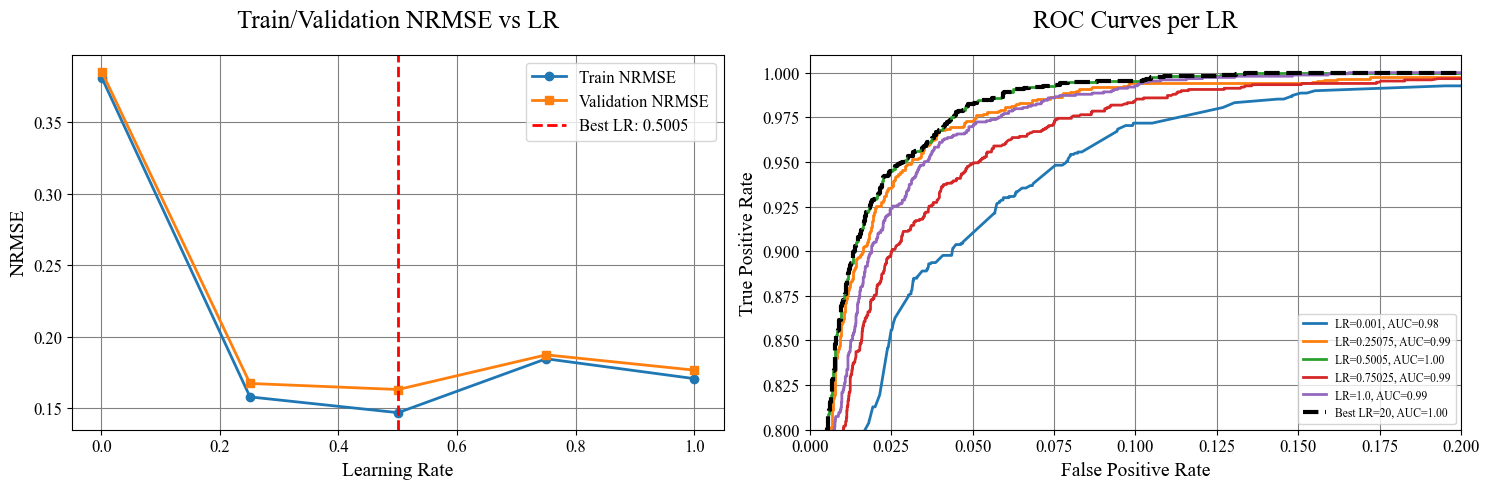

In [38]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(learnings, train_errors, label='Train NRMSE', marker='o')
plt.plot(learnings, val_errors, label='Validation NRMSE', marker='s')
plt.axvline(best_LR, color='r', linestyle='--', label=f'Best LR: {best_LR}')
plt.xlabel('Learning Rate')
plt.ylabel('NRMSE')
plt.title('Train/Validation NRMSE vs LR')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for lr in learnings:
    fpr, tpr, roc_auc = roc_curves[lr]
    plt.plot(fpr, tpr, lw=2, label=f'LR={lr}, AUC={roc_auc:.2f}')

fpr, tpr, roc_auc = roc_curves[best_LR]
plt.plot(fpr, tpr, lw=3, color='black', label=f'Best LR={best_depth}, AUC={roc_auc:.2f}', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per LR')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1.01)

plt.tight_layout()
plt.show()

In [37]:
test_pred = clf.predict(X_test)
print(f'Tets RMSE : {root_mean_squared_error(y_test, test_pred):.2}')
fpr, tpr, _ = roc_curve(y_test, test_pred)
print(f'TEST (FPR, TPR) : ({fpr[1]:.2},{tpr[1]:.2})')
print(f'TEST AUC        : {auc(fpr, tpr):.2}')

Tets RMSE : 0.19
TEST (FPR, TPR) : (0.021,0.87)
TEST AUC        : 0.92
